# <font color=black>Entrainer, régler et valider un algorithme de classification avec la bonne méthodologie </font>

# <font color=blue>Entrainement et evaluation d'un modèle de classification</font>

In [83]:
    #Chargement des bibliothèques
import numpy as np
import psycopg2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pip
from datetime import datetime
from apyori import apriori 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc

In [84]:
#DB connexion
def DbConnect():
    conn = psycopg2.connect(host="localhost",database="FormulaOne",port=5432,user='postgres',password='root')
    return conn

In [85]:
circuit = pd.read_sql('select * from "CircuitDim"', con=DbConnect())
races= pd.read_sql('select * from "RaceDim"', con=DbConnect())
date= pd.read_sql('select * from "DateTimeDim"', con=DbConnect())
driver= pd.read_sql('select * from "DriverDim"', con=DbConnect())
constructor= pd.read_sql('select * from "ConstructorsDim"', con=DbConnect())
weather= pd.read_sql('select * from "WeatherDim"', con=DbConnect())
qualifyingFact= pd.read_sql('select * from "QualifyingFact"', con=DbConnect())

C:\Anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\Anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\Anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\Anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are no

In [86]:
races.rename(columns = {'datetime_fk':'dateId'}, inplace = True)
races.rename(columns = {'circuit_fk':'CircuitId'}, inplace = True)
races.rename(columns = {'weather_fk':'weatherID'}, inplace = True)
qualifyingFact.rename(columns = {'race_fk':'raceId'}, inplace = True)
qualifyingFact.rename(columns = {'driver_fk':'DriverID'}, inplace = True)
qualifyingFact.rename(columns = {'constructor_fk':'constructorId'}, inplace = True)

In [87]:
df1 = pd.merge(races,date, on='dateId', how='inner')
df2 = pd.merge(df1,circuit, on='CircuitId', how='inner')
df4 = pd.merge(df2,weather, on='weatherID', how='inner')
df3 = pd.merge(qualifyingFact,df4, on='raceId', how='inner')
df3 = pd.merge(df3,driver, on='DriverID', how='inner')
Fact = pd.merge(df3,constructor, on='constructorId', how='inner')

In [88]:
Fact=Fact.drop(Fact[(Fact["year"] <=2014)].index)

#####  Checking for null Data

In [89]:
Fact.isnull().sum()*100/len(Fact)

raceId                     0.000000
DriverID                   0.000000
constructorId              0.000000
number                     0.000000
position                   0.000000
q1                         1.121857
q2                        26.615087
q3                        52.030948
round                      0.000000
name_x                     0.000000
CircuitId                  0.000000
dateId                     0.000000
weatherID                  0.000000
date                       0.000000
day                        0.000000
month                      0.000000
year                       0.000000
time                       0.000000
circuitRef                 0.000000
name_y                     0.000000
location                   0.000000
latitude                   0.000000
longitude                  0.000000
Altitude                   0.000000
country                    0.000000
img                        0.000000
weather                   39.110251
DriverRef                  0

##### Coding null variables

In [90]:
Fact['weather'].fillna(Fact['weather'].mode().iloc[0], inplace=True)
Fact['car'].fillna(Fact['car'].mode().iloc[0], inplace=True)
Fact['points'].fillna(Fact['points'].median(), inplace=True)

Fact['q1']=Fact['q1'].replace("None", "0", regex=True)
Fact['q2']=Fact['q2'].replace("None", "0", regex=True)
Fact['q3']=Fact['q3'].replace("None", "0", regex=True)


position is in 1 to 22 range so in order to obtian a more accurate efficient classification result we coded the position in 1 to 4 range

1 highly performant

2 performant

3 averagely performant

4 unperformant

In [91]:
Fact['position_perf']=0
for i in range(0,len(Fact)):
    pos=Fact['position'].iat[i]
    if pos>0 and pos<6:
         Fact['position_perf'].iat[i] = int(1)
    elif pos>5 and pos<11:
         Fact['position_perf'].iat[i] = int(2)
    elif pos>10 and pos<16:
         Fact['position_perf'].iat[i] = int(3)
    else:
         Fact['position_perf'].iat[i] = int(4)

In [92]:
Fact.tail()

,raceId,DriverID,constructorId,number,position,q1,q2,q3,round,name_x,...,ForeName,SurName,Dob,Nationality,points,car,constructorRef,constructorName,constructorNationality,position_perf
4754,964,839,209,31,21,00:01:33.353000,None,None,17,Japanese Grand Prix,...,Esteban,Ocon,1996-09-17,French,74.0,Alpine Renault,manor,Manor Marussia,British,4
4755,965,839,209,31,22,00:01:38.806000,None,None,18,United States Grand Prix,...,Esteban,Ocon,1996-09-17,French,74.0,Alpine Renault,manor,Manor Marussia,British,4
4756,966,839,209,31,20,00:01:21.881000,None,None,19,Mexican Grand Prix,...,Esteban,Ocon,1996-09-17,French,74.0,Alpine Renault,manor,Manor Marussia,British,4
4757,967,839,209,31,20,00:01:13.432000,None,None,20,Brazilian Grand Prix,...,Esteban,Ocon,1996-09-17,French,74.0,Alpine Renault,manor,Manor Marussia,British,4
4758,968,839,209,31,20,00:01:42.286000,None,None,21,Abu Dhabi Grand Prix,...,Esteban,Ocon,1996-09-17,French,74.0,Alpine Renault,manor,Manor Marussia,British,4


In [93]:
Fact.isnull().sum()*100/len(Fact)

raceId                     0.000000
DriverID                   0.000000
constructorId              0.000000
number                     0.000000
position                   0.000000
q1                         1.121857
q2                        26.615087
q3                        52.030948
round                      0.000000
name_x                     0.000000
CircuitId                  0.000000
dateId                     0.000000
weatherID                  0.000000
date                       0.000000
day                        0.000000
month                      0.000000
year                       0.000000
time                       0.000000
circuitRef                 0.000000
name_y                     0.000000
location                   0.000000
latitude                   0.000000
longitude                  0.000000
Altitude                   0.000000
country                    0.000000
img                        0.000000
weather                    0.000000
DriverRef                  0

##### Cleaning

In [94]:
Fact["nameDriver"]=Fact["ForeName"]+" "+Fact["SurName"]
Fact["nameDriver"]
Fact['Dob']=pd.to_datetime(Fact['Dob'])
date=datetime.today()-Fact['Dob']
Fact['age']=round(date.dt.days/365)

Calculating the drivers' age is more significant that having a birth date as it provides us a mesurable value.

In [95]:
Fact.drop(columns=['raceId',
                   'DriverID',
                   'constructorId',
                   'CircuitId',
                   'dateId',
                   'constructorRef',
                   'DriverRef',
                   'circuitRef',
                   'ForeName',
                   'SurName',
                   'Dob',
                   'number',
                   'Number',
                   'Code',
                    'day',
                   'month',
                   'position'],axis=1,inplace=True)

In [96]:
Fact.rename(columns = {'name_x':'nameGP','name_y':'nameCircuit'}, inplace = True)

Converting Q1/Q2/Q3 to microsecond

In [97]:
Fact['q1_sec']=0
for i in range(0,len(Fact)):
    t=Fact['q1'].iat[i]
    if t is None:
        Fact['q1_sec'].iat[i] = int(0)
    else:
        Fact['q1_sec'].iat[i] = int(t.hour*3600000000+t.minute*60000000+t.second*1000000+t.microsecond)

In [98]:
Fact['q2_sec']=0
for i in range(0,len(Fact)):
    t=Fact['q2'].iat[i]
    if t is None:
        Fact['q2_sec'].iat[i] = int(0)
    else:
        Fact['q2_sec'].iat[i] = int(t.hour*3600000000+t.minute*60000000+t.second*1000000+t.microsecond)

In [99]:
Fact['q3_sec']=0
for i in range(0,len(Fact)):
    t=Fact['q3'].iat[i]
    if t is None:
        Fact['q3_sec'].iat[i] = int(0)
    else:
        Fact['q3_sec'].iat[i] = int(t.hour*3600000000+t.minute*60000000+t.second*1000000+t.microsecond)

## Algorithms

driver's performance in QS

In [100]:
DriverPQS=Fact.drop(columns=['nameGP',
                   'date',
                   'img',
                   'points',
                   'time',
                   'round',
                   'nameCircuit',
                    'location',
                    'latitude',
                    'longitude',
                    'Altitude',
                    'country',
                    'Nationality',
                    'constructorName',
                    'constructorNationality',
                    'weatherID',
                    'q1',
                    'q2',
                    'q3'])

In [101]:
DriverPQS.isnull().sum()*100/len(DriverPQS)

year             0.0
weather          0.0
car              0.0
position_perf    0.0
nameDriver       0.0
age              0.0
q1_sec           0.0
q2_sec           0.0
q3_sec           0.0
dtype: float64

In [102]:
DriverPQS

,year,weather,car,position_perf,nameDriver,age,q1_sec,q2_sec,q3_sec
127,2015,Half Cloudy,Alpine Renault,4,Fernando Alonso,41.0,101746000,0,0
128,2015,Half Cloudy,Alpine Renault,4,Fernando Alonso,41.0,99280000,0,0
129,2015,Half Cloudy,Alpine Renault,3,Fernando Alonso,41.0,95205000,95039000,0
130,2015,Half Cloudy,Alpine Renault,3,Fernando Alonso,41.0,87941000,87760000,0
131,2015,Half Cloudy,Alpine Renault,3,Fernando Alonso,41.0,77778000,86632000,0
...,...,...,...,...,...,...,...,...,...
4754,2016,Half Cloudy,Alpine Renault,4,Esteban Ocon,26.0,93353000,0,0
4755,2016,Half Cloudy,Alpine Renault,4,Esteban Ocon,26.0,98806000,0,0
4756,2016,Half Cloudy,Alpine Renault,4,Esteban Ocon,26.0,81881000,0,0
4757,2016,Half Cloudy,Alpine Renault,4,Esteban Ocon,26.0,73432000,0,0


##### Variables encoding

In [103]:
from sklearn.preprocessing import LabelEncoder
lb_make = LabelEncoder()
DriverPQS["weather"] = lb_make.fit_transform(DriverPQS["weather"])
DriverPQS["car"] = lb_make.fit_transform(DriverPQS["car"])
DriverPQS["nameDriver"] = lb_make.fit_transform(DriverPQS["nameDriver"])

In [104]:
DriverPQS.tail()

,year,weather,car,position_perf,nameDriver,age,q1_sec,q2_sec,q3_sec
4754,2016,2,2,4,9,26.0,93353000,0,0
4755,2016,2,2,4,9,26.0,98806000,0,0
4756,2016,2,2,4,9,26.0,81881000,0,0
4757,2016,2,2,4,9,26.0,73432000,0,0
4758,2016,2,2,4,9,26.0,102286000,0,0


In [105]:
DriverPQS.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2585 entries, 127 to 4758
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   year           2585 non-null   int64  
 1   weather        2585 non-null   int32  
 2   car            2585 non-null   int32  
 3   position_perf  2585 non-null   int64  
 4   nameDriver     2585 non-null   int32  
 5   age            2585 non-null   float64
 6   q1_sec         2585 non-null   int64  
 7   q2_sec         2585 non-null   int64  
 8   q3_sec         2585 non-null   int64  
dtypes: float64(1), int32(3), int64(5)
memory usage: 171.7 KB


# LogisticRegression

In [106]:
#separate the other attributes from the predicting attribute
X = DriverPQS.drop(columns=['position_perf'])
#separte the predicting attribute into Y for model training
y = DriverPQS['position_perf']

In [107]:
# importing train_test_split from sklearn
from sklearn.model_selection import train_test_split
# splitting the data
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=5)

In [108]:
#normalise with StandardScaler
Sc=StandardScaler()
X_train=Sc.fit_transform(X_train)
X_test=Sc.transform(X_test)

In [109]:
# creating an object of LogisticRegression class
logreg=LogisticRegression(multi_class='multinomial', solver='lbfgs')
# fitting the training data
logreg.fit(X_train,y_train)

LogisticRegression(multi_class='multinomial')

In [110]:
from sklearn.metrics import plot_confusion_matrix, classification_report

In [111]:
y_pred=logreg.predict(X_test)

C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


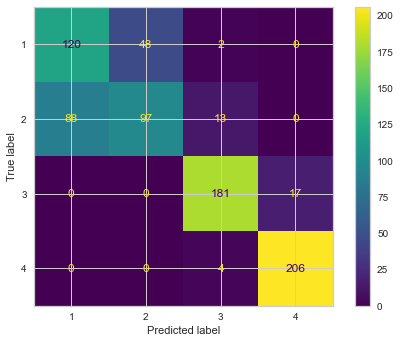

In [112]:
# confusion matrix
plot_confusion_matrix(logreg,X_test,y_test)

###### (47)1 were classified as 2, 2 as 3 
###### (95)2 were classified as 1, 14 as 3
###### (16)3 were classified as 4
###### (4)4 were classified as 3

In [113]:
#classification report
print(classification_report(y_test,y_pred,digits=6))

              precision    recall  f1-score   support

           1   0.576923  0.705882  0.634921       170
           2   0.668966  0.489899  0.565598       198
           3   0.905000  0.914141  0.909548       198
           4   0.923767  0.980952  0.951501       210

    accuracy                       0.778351       776
   macro avg   0.768664  0.772719  0.765392       776
weighted avg   0.777981  0.778351  0.772978       776



###### ROC and AUC curve

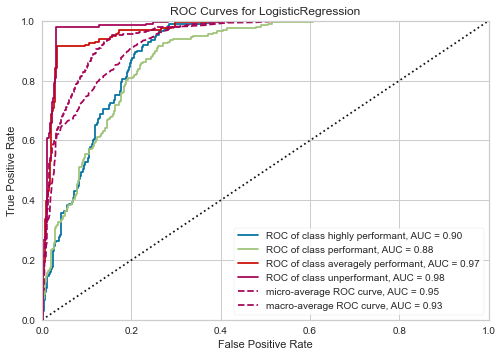

<AxesSubplot:title={'center':'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [114]:
from yellowbrick.classifier import ROCAUC

def plot_ROC_curve(logreg, X_train, y_train, X_test, y_test):

    # Creating visualization with the readable labels
    visualizer = ROCAUC(logreg, encoder={1: 'highly performant', 
                                        2: 'performant', 
                                        3: 'averagely performant', 
                                        4: 'unperformant'})
                                        
    # Fitting to the training data first then scoring with the test data                                    
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.show()
    
    return visualizer
plot_ROC_curve(logreg, X_train, y_train, X_test, y_test).show()

Average of AUC metric= 0.93

# KNN

optimise number of neighbors

In [115]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
val_score=[]
K=np.arange(1,50)
for i in K:
    score=cross_val_score(KNeighborsClassifier(n_neighbors=i),X_train,y_train,cv=5)
    val_score.append(score.mean())

val_score

[0.7932752789213511,
 0.7589997092177958,
 0.8104115333404753,
 0.7999051131754947,
 0.8181539921335762,
 0.8076445111032889,
 0.8153823785984298,
 0.799906643608148,
 0.81261841722655,
 0.8043219418129505,
 0.8015610413063772,
 0.7954791019421189,
 0.7987970799344974,
 0.8004545384980334,
 0.7999035827428415,
 0.797136560505655,
 0.7971426822362682,
 0.7982445937466521,
 0.7988016712324575,
 0.7976997597220734,
 0.7993572182856093,
 0.7982491850446121,
 0.7960407707258842,
 0.7976982292894201,
 0.7999112349061079,
 0.7965901960484228,
 0.794381781729695,
 0.7921703065456605,
 0.7938262346765431,
 0.7932737484886978,
 0.7960423011585375,
 0.7916162899251619,
 0.794381781729695,
 0.789954240063666,
 0.7921672456803539,
 0.7927166710028926,
 0.7916116986272019,
 0.7949281461869271,
 0.7899557704963194,
 0.7916116986272019,
 0.788852328553282,
 0.7910638037373166,
 0.7916147594925085,
 0.788852328553282,
 0.7927258535988125,
 0.7894109364717407,
 0.7877534779082046,
 0.7883013727980901,
 

In [116]:
print(len(val_score))

49


meilleur valeur= 5


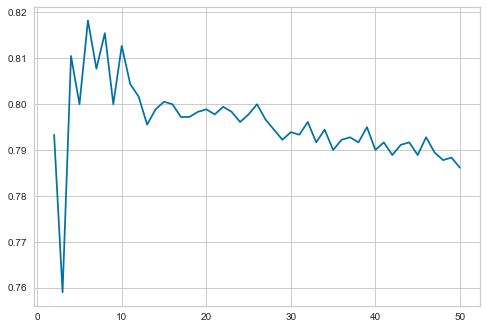

In [117]:
import matplotlib.pyplot as plt
plt.plot(K+1,val_score)
print('meilleur valeur=',np.argmax(val_score)+1)

In [118]:
# chargement du modèle KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier 
# Entrainer le modèle avec la méthode fit
KNN=KNeighborsClassifier(n_neighbors=5) 
KNN.fit(X_train,y_train)



KNeighborsClassifier()

In [119]:
# Calculate models' score
y_pred=KNN.predict(X_test)
print(KNN.score(X_train,y_train))
print(KNN.score(X_test, y_test))


0.867330016583748
0.8337628865979382


              precision    recall  f1-score   support

           1       0.69      0.80      0.74       170
           2       0.79      0.64      0.71       198
           3       0.90      0.90      0.90       198
           4       0.93      0.98      0.95       210

    accuracy                           0.83       776
   macro avg       0.83      0.83      0.83       776
weighted avg       0.84      0.83      0.83       776



C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


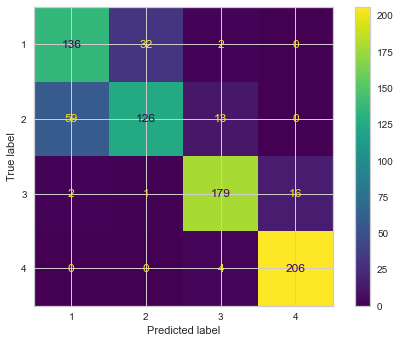

In [120]:
# confusion matrix
from sklearn.metrics import plot_confusion_matrix, classification_report
plot_confusion_matrix(KNN,X_test,y_test)
print(classification_report(y_test, y_pred))

###### ROC and AUC curve

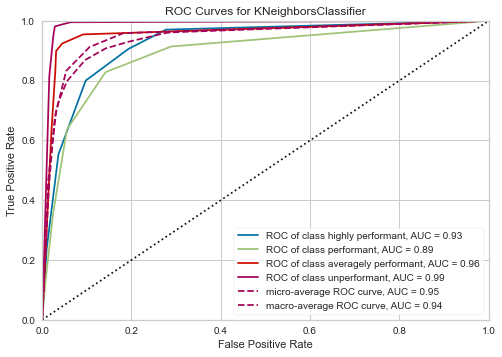

<AxesSubplot:title={'center':'ROC Curves for KNeighborsClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [121]:
plot_ROC_curve(KNN, X_train, y_train, X_test, y_test).show()

Average of AUC metric= 0.93

# SVM

In [122]:
from sklearn.svm import SVC
model1=SVC(kernel='linear')
model1=model1.fit(X_train,y_train)

In [123]:
y_pred=model1.predict(X_test)

In [124]:
#linear model
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[115  53   2   0]
 [ 81 104  13   0]
 [  0   0 181  17]
 [  0   0   4 206]]
              precision    recall  f1-score   support

           1       0.59      0.68      0.63       170
           2       0.66      0.53      0.59       198
           3       0.91      0.91      0.91       198
           4       0.92      0.98      0.95       210

    accuracy                           0.78       776
   macro avg       0.77      0.77      0.77       776
weighted avg       0.78      0.78      0.78       776



###### (52)1 were classified as 2, 2 as 3 
###### (86)2 were classified as 1, 14 as 3
###### (16)3 were classified as 4
###### (4)4 were classified as 3

###### ROC and AUC curve

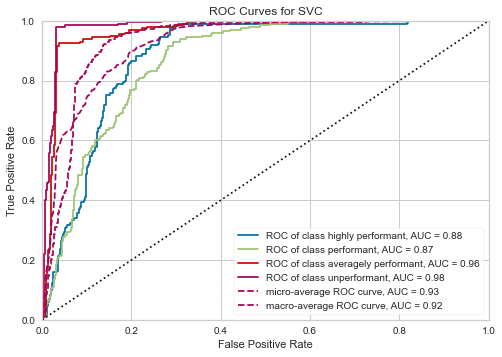

<AxesSubplot:title={'center':'ROC Curves for SVC'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [125]:
plot_ROC_curve(model1, X_train, y_train, X_test, y_test).show()

Average of AUC metric= 0.92

In [126]:
#poly model
from sklearn.svm import SVC
model2=SVC(kernel='poly',degree=3)
model2.fit(X_train,y_train)
y_pred2=model2.predict(X_test)
print(confusion_matrix(y_test,y_pred2))
print(classification_report(y_test,y_pred2))

[[132  36   2   0]
 [ 59 126  13   0]
 [  0   0 181  17]
 [  0   0   4 206]]
              precision    recall  f1-score   support

           1       0.69      0.78      0.73       170
           2       0.78      0.64      0.70       198
           3       0.91      0.91      0.91       198
           4       0.92      0.98      0.95       210

    accuracy                           0.83       776
   macro avg       0.82      0.83      0.82       776
weighted avg       0.83      0.83      0.83       776



###### (33)1 were classified as 2, 2 as 3 
###### (66)2 were classified as 1, 14 as 3
###### (16)3 were classified as 4
###### (4)4 were classified as 3

###### ROC and AUC curve

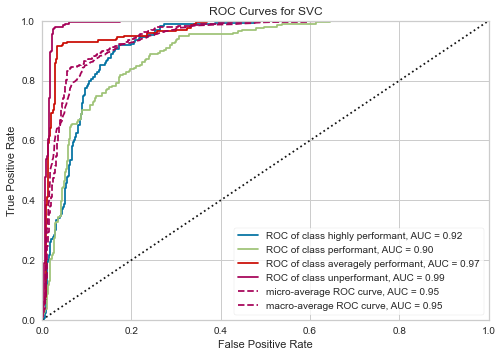

<AxesSubplot:title={'center':'ROC Curves for SVC'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [127]:
plot_ROC_curve(model2, X_train, y_train, X_test, y_test).show()

Average of AUC metric= 0.94

In [128]:
#Gaussian kernel
model3=SVC(kernel='rbf')
model3.fit(X_train,y_train)
y_pred3=model3.predict(X_test)
print(confusion_matrix(y_test,y_pred3))
print(classification_report(y_test,y_pred3))

[[127  41   2   0]
 [ 64 121  13   0]
 [  0   0 181  17]
 [  0   0   4 206]]
              precision    recall  f1-score   support

           1       0.66      0.75      0.70       170
           2       0.75      0.61      0.67       198
           3       0.91      0.91      0.91       198
           4       0.92      0.98      0.95       210

    accuracy                           0.82       776
   macro avg       0.81      0.81      0.81       776
weighted avg       0.82      0.82      0.82       776



###### ROC and AUC curve

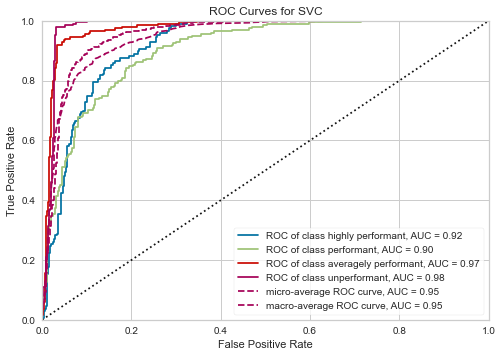

<AxesSubplot:title={'center':'ROC Curves for SVC'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [129]:
plot_ROC_curve(model3, X_train, y_train, X_test, y_test).show()

Average of AUC metric= 0.94

###### (39)1 were classified as 2, 2 as 3 
###### (68)2 were classified as 1, 14 as 3
###### (16)3 were classified as 4
###### (4)4 were classified as 3

In [130]:
from sklearn.model_selection import GridSearchCV 
  
#defining parameter range 
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}  
  
grid = GridSearchCV(SVC(), param_grid, refit = True) 
  
# fitting the model for grid search 
grid.fit(X_train, y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']})

In [131]:
print("Best params withGridSeachCV")
print(grid.best_params_)

Best params withGridSeachCV
{'C': 1, 'gamma': 1, 'kernel': 'rbf'}


In [132]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
# We will display a table which orders the models from the most efficient to the least efficient according to the score
s1=accuracy_score(y_test, y_pred)
s2=accuracy_score(y_test, y_pred2)
s3=accuracy_score(y_test, y_pred3)

models = pd.DataFrame({
    'Model': [ 'Support Vector Machines Linaire','Support Vector Machines polynomiale',
              'Support Vector Machines RBF'],
    'Score': [s1,s2, s3]})
models.sort_values(by="Score",ascending=False)

,Model,Score
1,Support Vector Machines polynomiale,0.831186
2,Support Vector Machines RBF,0.818299
0,Support Vector Machines Linaire,0.780928


=> Support Vector Machines polynomiale has the highest score therefore is the best model

# ADD

In [133]:
# splitting the data
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=5)

In [134]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=0)
dt.fit(X_train, y_train);

In [135]:
print('training accuracy = ' + str(dt.score(X_train, y_train)))

training accuracy = 1.0


In [136]:
print('test accuracy = '+ str(dt.score(X_test, y_test)))

test accuracy = 0.8221649484536082


In [137]:
X_train

,year,weather,car,nameDriver,age,q1_sec,q2_sec,q3_sec
899,2017,2,11,41,33.0,104773000,103249000,103094000
2676,2018,2,15,22,32.0,94170000,93995000,95196000
1731,2018,2,3,19,24.0,95480000,0,0
1987,2015,2,3,37,35.0,102941000,0,0
525,2018,1,10,40,30.0,72463000,72440000,0
...,...,...,...,...,...,...,...,...
2040,2018,5,3,37,35.0,72538000,72505000,71212000
4162,2018,1,13,39,32.0,69217000,68741000,0
2950,2019,0,1,7,28.0,99957000,0,0
3381,2017,4,13,23,25.0,94899000,94716000,93658000


In [147]:
test={'year':['2018'],'weather':['1'],'car':['11'],'nameDriver':['41'],'age':['70'],'q1_sec':['94170000'],'q2_sec':['72505000'],'q3_sec':['93658000']}
df=pd.DataFrame(test)
pred = dt.predict(df)
print(pred)

[1]


In [ ]:
import pickle
pickle.dump(regressor, open('performancePredictorInRace.pkl','wb'))

# Loading model to compare the results
model = pickle.load(open('performancePredictorInRace.pkl','rb'))

#### We have a training accuracy equivalent to 1.0 which means that our model is overfitting

#### Confusion matrix?

In [55]:
from sklearn.metrics import confusion_matrix
y_pred = dt.predict(X_test)
print(confusion_matrix(y_test, y_pred))

[[135  34   1   0]
 [ 51 134  13   0]
 [  1   8 172  17]
 [  0   0  13 197]]


###### (27)1 were classified as 2, 1 as 3 
###### (51)2 were classified as 1, 14 as 3
###### (6)3 were classified as 3, 18 as 4
###### (17)4 were classified as 3

#### Classification report

In [56]:
from sklearn.metrics import classification_report
pred_dt= dt.predict(X_test)
print(classification_report(y_test, pred_dt))

              precision    recall  f1-score   support

           1       0.72      0.79      0.76       170
           2       0.76      0.68      0.72       198
           3       0.86      0.87      0.87       198
           4       0.92      0.94      0.93       210

    accuracy                           0.82       776
   macro avg       0.82      0.82      0.82       776
weighted avg       0.82      0.82      0.82       776



#### Create a dictionary __`param_grid`__, to configure these 2 hyperparametres :
##### - __`criterion`__ : Gini or entropie
##### - __`max_depth`__ : 1 to 9

In [57]:
param_grid = {'criterion': ['gini', 'entropy'],'max_depth': np.arange(1,10)}

#### Create a grid search instance applied to the decision tree classification algorithm. Search should test all combinations of hyperparameter values #

In [58]:
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9])})

#### Show best values of tuned hyperparameters

In [59]:
grid.best_params_

{'criterion': 'entropy', 'max_depth': 6}

best criterion is gini and the max depth is 6

#### Create a __`final_model`__ instance of the decision tree classification algorithm using the best hyperparameters

In [60]:
final_model = DecisionTreeClassifier(random_state=42, criterion='gini', max_depth=6)

In [61]:
fm=final_model.fit(X_train, y_train)

#### Evaluate the performance of final_model on the appropriate subset of data

In [62]:
print( 'Train score=',fm.score(X_train, y_train))
print( 'Test score=',fm.score(X_test, y_test))

Train score= 0.8916528468767275
Test score= 0.8685567010309279


C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


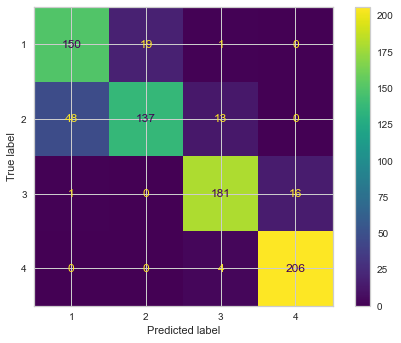

In [63]:
from sklearn.metrics import confusion_matrix
y_pred = fm.predict(X_test)
plot_confusion_matrix(fm,X_test,y_test)


###### (18)1 were classified as 2, 1 as 3 
###### (50)2 were classified as 1, 14 as 3
###### (16)3 were classified as 4
###### (5)4 were classified as 3

#### Classification_report

In [64]:
from sklearn.metrics import classification_report
y_pred = fm.predict(X_test)
print(classification_report(y_test, y_pred, digits=8 ))

              precision    recall  f1-score   support

           1  0.75376884 0.88235294 0.81300813       170
           2  0.87820513 0.69191919 0.77401130       198
           3  0.90954774 0.91414141 0.91183879       198
           4  0.92792793 0.98095238 0.95370370       210

    accuracy                      0.86855670       776
   macro avg  0.86736241 0.86734148 0.86314048       776
weighted avg  0.87239773 0.86855670 0.86634984       776



###### ROC and AUC curve

C:\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


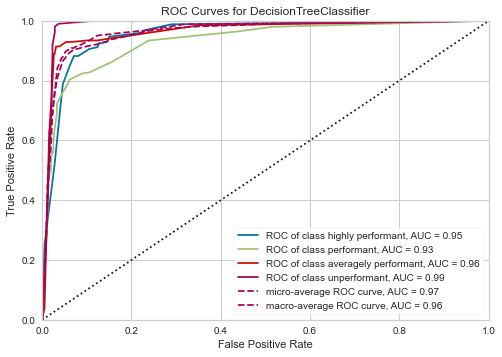

<AxesSubplot:title={'center':'ROC Curves for DecisionTreeClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [65]:
plot_ROC_curve(fm, X_train, y_train, X_test, y_test).show()

Average of AUC metric= 0.96

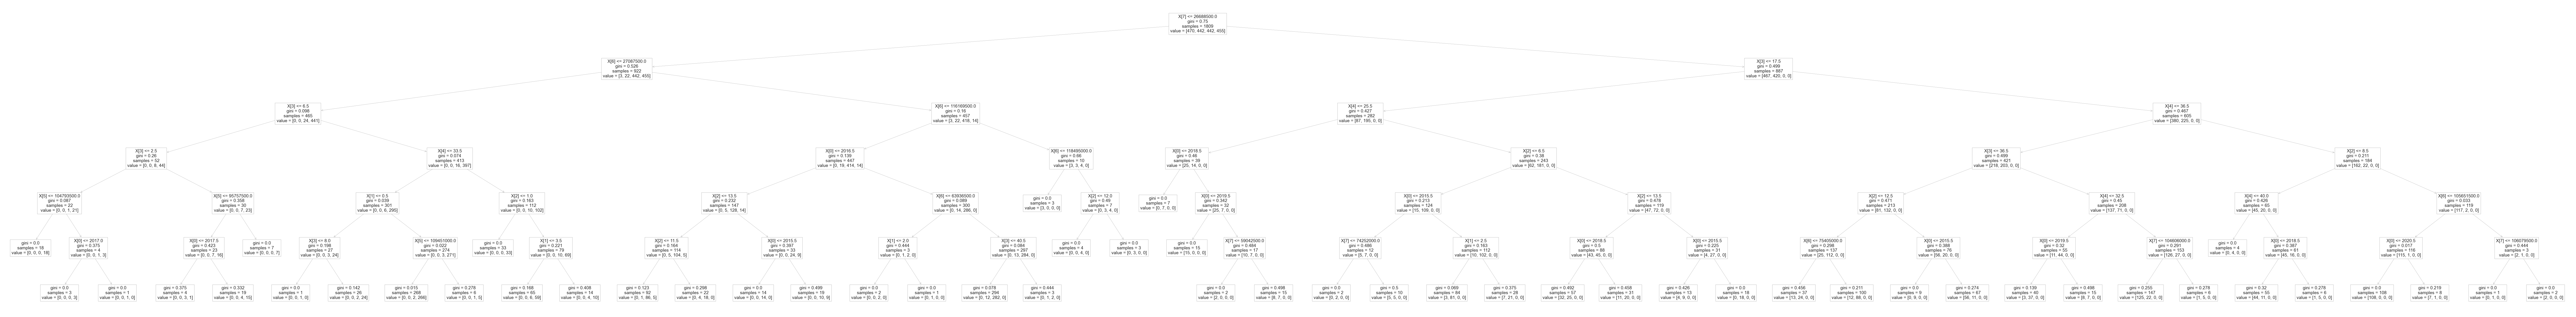

In [66]:
import matplotlib.pyplot as plt 
from sklearn import tree
plt.figure(figsize=(200, 25))
tree.plot_tree(fm)
plt.savefig('DecisionTree.png')

In [67]:
names= ['q1_sec','q2_sec','q3_sec','year','weather','car','nameDriver','age']

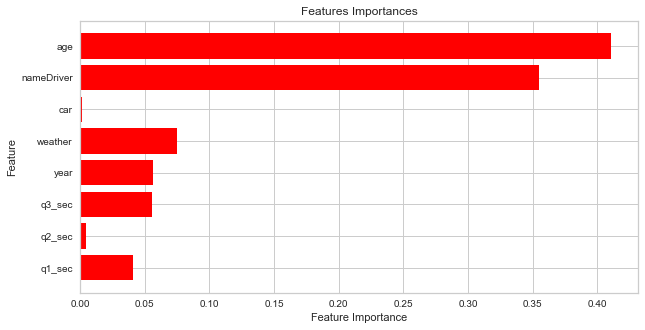

In [68]:
import numpy as np

def fonctionArbre(model):
    plt.figure(figsize=(10,5))
    plt.barh(range(len(names)), model.feature_importances_, align='center', color='red')
    plt.yticks(np.arange(len(names)), names)
    plt.title('Features Importances')
    plt.xlabel("Feature Importance")
    plt.ylabel("Feature")
    plt.grid(True)
fonctionArbre(fm)
plt.show()

In [69]:
print(fm.feature_importances_)

[0.04135854 0.0043352  0.05583092 0.05621764 0.07512961 0.00159704
 0.35472764 0.41080341]


(0.85, 4.15, 0.85, 4.15)

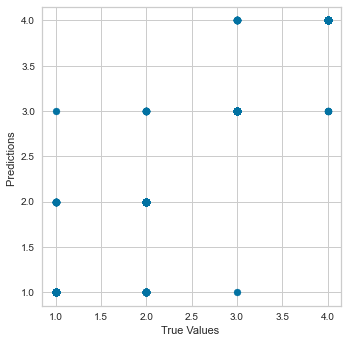

In [70]:
g=plt.scatter(y_test, y_pred)
g.axes.set_xlabel('True Values ')
g.axes.set_ylabel('Predictions ')
g.axes.axis('equal')
g.axes.axis('square')

In [71]:
test={'year':['2023'],'weather':['2'],'car':['5'],'nameDriver':['10'],'age':['35'],'q1_sec':['622222000'],'q2_sec':['622222000'],'q3_sec':['622222000']}

In [72]:
df=pd.DataFrame(test)

In [73]:
pred = fm.predict(df)

In [74]:
print(pred)

[2]


# Random forest

In [75]:
from sklearn.ensemble import RandomForestClassifier

In [76]:
classifier = RandomForestClassifier(n_estimators=15, random_state=0)
rc=classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

In [77]:
print( 'Train_score=',classifier.score(X_train, y_train))
print( 'Test_score=',classifier.score(X_test, y_test))

Train_score= 0.9977888336097291
Test_score= 0.8595360824742269


In [78]:
#confusion matrix
from sklearn.metrics import confusion_matrix
y_pred = classifier.predict(X_test)
print(confusion_matrix(y_test, y_pred))

[[139  30   1   0]
 [ 38 147  13   0]
 [  0   4 177  17]
 [  0   0   6 204]]


###### (25)1 were classified as 2, 1 as 3 
###### (39)2 were classified as 1, 14 as 3
###### (5)3 were classified as 2, 16 as 4
###### (7)4 were classified as 3

In [79]:
y_pred = classifier.predict(X_test)
print(classification_report(y_test, y_pred, digits=8 ))

              precision    recall  f1-score   support

           1  0.78531073 0.81764706 0.80115274       170
           2  0.81215470 0.74242424 0.77572559       198
           3  0.89847716 0.89393939 0.89620253       198
           4  0.92307692 0.97142857 0.94663573       210

    accuracy                      0.85953608       776
   macro avg  0.85475488 0.85635982 0.85492915       776
weighted avg  0.85831712 0.85953608 0.85828768       776



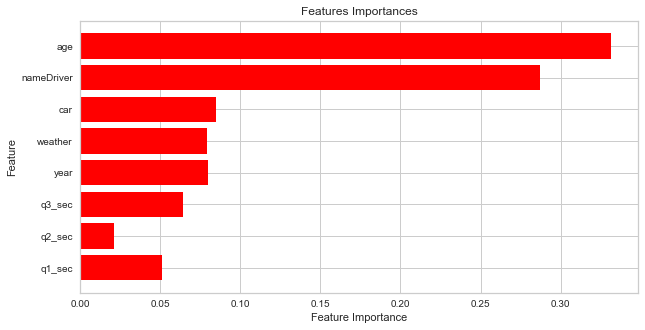

In [80]:
import numpy as np

def fonctionArbre(model):
    plt.figure(figsize=(10,5))
    plt.barh(range(len(names)), model.feature_importances_, align='center', color='red')
    plt.yticks(np.arange(len(names)), names)
    plt.title('Features Importances')
    plt.xlabel("Feature Importance")
    plt.ylabel("Feature")
    plt.grid(True)
fonctionArbre(classifier)
plt.show()

###### ROC and AUC curve

C:\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


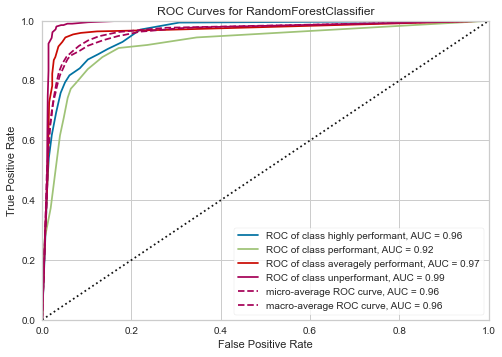

<AxesSubplot:title={'center':'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [81]:
plot_ROC_curve(classifier, X_train, y_train, X_test, y_test).show()

Average of AUC metric= 0.95

In [82]:
print(classifier.feature_importances_)

[0.05118531 0.02153789 0.06458428 0.07964955 0.07949689 0.08469516
 0.28720627 0.33164465]


After comparing the models, we choose to maintain the DecisionTreeClassifier model as it has the best accuracy, f1-score, precision and AUC metric 